In [1]:
import sys
sys.path.append("/mnt/Data16Tc/home/haichao/code/SpaCon/")
from scipy.sparse import coo_matrix, save_npz, load_npz
from Cluster_Network.utils import Batch_Data_3D, Transfer_pytorch_Data, Transfer_pytorch_NT_Data
# from Cluster_Network.adjacency_matrix_calculate import Cal_Spatial_Net_3D, Stats_Spatial_Net
from Cluster_Network.adjacency_matrix_calculate_modify import Cal_Spatial_Net_3D, Stats_Spatial_Net
# from Cluster_Network.model_pyg import GATE_PyG, GATE_PyG_3Layers, GATE_PyG_3Layers_Encapsulation
# from Cluster_Network.AutoEncoder_pyg import GATE_PyG_3Layers_Encapsulation_Spa, GATE_PyG_3Layers_Encapsulation_Con, GATE_2Encoder_Concat_Feature_Decoder
# from Cluster_Network.model_pyg_gatev2 import GATEv2_2Encoder
from Cluster_Network.model_pyg_gate_skip_connect import GATE_2Encoder_Decoder_Init, GATE_2Encoder
from Cluster_Network.r_mcluster import mclust_R
from torch_geometric.loader import DataLoader, NeighborLoader
import torch.nn.functional as F
import copy
import datetime
import os
import time
import scipy.sparse as sp
import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io
import h5py
import json
import torch
import numpy as np
from tqdm import tqdm
from numba import jit
import pickle

import warnings
warnings.filterwarnings("ignore")

mus = 'mouse_1'
if mus == 'mouse_1':
    plot_x, plot_y = 'z', 'y'
    figsize1 = (5,5)
    figsize2 = (4,5)
elif mus == 'mouse_3':
    plot_x, plot_y = 'x', 'y'
    figsize1 = (11,5)
    figsize2 = (9,5)

In [40]:
import numpy as np

# 定义指数变换函数
def f_exponential(x, a):
    return (np.exp(-a * x) - 1) / (np.exp(-a) - 1)

# 给定一个参数a
a = 4  # 可以调节的参数

# 计算f(x)在不同点的值
x_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
f_values = [f_exponential(x, a) for x in x_values]

# 输出结果
for x, f_x in zip(x_values, f_values):
    print(f"f({x}) = {f_x}")


f(0) = -0.0
f(0.1) = 0.3358309116701862
f(0.2) = 0.5609451038411362
f(0.3) = 0.711843659500443
f(0.4) = 0.8129939862767013
f(0.5) = 0.8807970779778824
f(1) = 1.0


#### load adata

In [2]:
adata = sc.read_h5ad(f'./data/{mus}/adata_merge.h5ad')
print('raw adata shape:', adata.shape)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

gene = pd.read_csv(f'/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/{mus}/gene.csv')
adata.var = pd.merge(adata.var, gene, how='left', left_index=True, right_on='gene_identifier')
adata.var = adata.var.set_index('gene_symbol')
adata.var

# sc.pp.log1p(adata)  # add this to make the hightly_variable work
# n_top_genes = 3000
# sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_top_genes)
# adata = adata[:, adata.var.highly_variable]
# adata

raw adata shape: (250535, 1122)


,gene_identifier,name,mapped_ncbi_identifier
gene_symbol,,,
Ccnd2,ENSMUSG00000000184,cyclin D2,NCBIGene:12444
Th,ENSMUSG00000000214,tyrosine hydroxylase,NCBIGene:21823
Lhx2,ENSMUSG00000000247,LIM homeobox protein 2,NCBIGene:16870
Glra1,ENSMUSG00000000263,"glycine receptor, alpha 1 subunit",NCBIGene:14654
Pparg,ENSMUSG00000000440,peroxisome proliferator activated receptor gamma,NCBIGene:19016
...,...,...,...
9630002D21Rik,ENSMUSG00000114028,RIKEN cDNA 9630002D21 gene,NaN
C730002L08Rik,ENSMUSG00000114469,RIKEN cDNA C730002L08 gene,NCBIGene:320155
D130079A08Rik,ENSMUSG00000115424,RIKEN cDNA D130079A08 gene,NCBIGene:320671


100%|██████████| 128/128 [20:53<00:00,  9.79s/it]


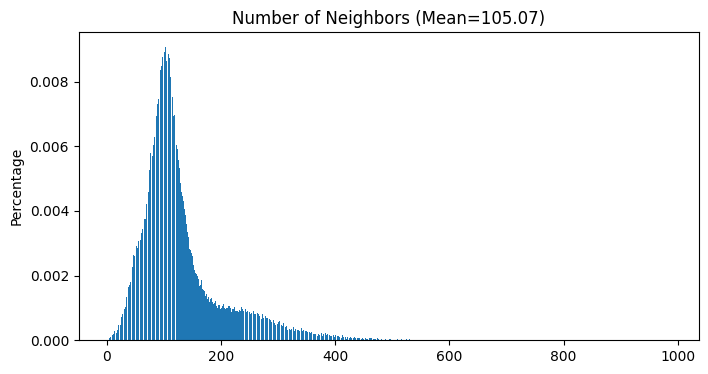

The proportion of the ST adj matrix is:  0.0003385011369341153


Data(x=[250535, 1122], edge_index=[2, 21246967])

In [3]:
# Consturcting network for all adata (Test)
# build the section list
section_order = np.unique(adata.obs['section']).tolist()
# calculate the spatial net for the tem_data
Cal_Spatial_Net_3D(adata=adata,  rad_cutoff_2D=1.0, rad_cutoff_Zaxis=1.0,
                       section_x='x', section_y='y', key_section='section',
                       section_order=section_order, verbose=False)
Stats_Spatial_Net(adata)
ST_graph_data, st_adj = Transfer_pytorch_Data(adata)
ST_graph_data

In [3]:
# load PyG Data object
# mouse_1
eps = 0.001
proportion_after = 0.0211
with open(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/NT/zxw/{mus}/PyG_Data_eps{eps}_{proportion_after}.pkl', 'rb') as f:
    NT_graph_data = pickle.load(f)

with open(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/ST/zxw/{mus}/PyG_Data_xy0.7_z1.0.pkl', 'rb') as f:
    ST_graph_data = pickle.load(f)
st_adj = load_npz(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/ST/zxw/{mus}/zxw_adj.npz')
# mouse_3
# eps = 0.0008
# with open(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/NT/zxw/{mus}/PyG_Data_eps{eps}.pkl', 'rb') as f:
#     NT_graph_data = pickle.load(f)
# NT_graph_data


In [4]:
kwargs_train = {'num_neighbors': [20, 10, 10],
                'batch_size': 32,
                'num_workers': 4,
                'persistent_workers': True}
kwargs_test = {'num_neighbors': [-1],
               'batch_size': 32,
               'num_workers': 4,
               'persistent_workers': True}
# sampled node number is not the same
# loader_ST = NeighborLoader(ST_graph_data, num_neighbors=[10, 10], shuffle=False, **kwargs)
# train
loader_NT = NeighborLoader(NT_graph_data, shuffle=False, **kwargs_train)
# evaluate
subgraph_loader = NeighborLoader(copy.copy(NT_graph_data), input_nodes=None, shuffle=False, **kwargs_test)   # test_loader: num_neighbors=[-1]
# Add global node index information.
subgraph_loader.data.num_nodes = NT_graph_data.num_nodes
subgraph_loader.data.n_id = torch.arange(NT_graph_data.num_nodes)

# loader_ST = NeighborLoader(ST_graph_data, shuffle=False, **kwargs_train)
# evaluate
subgraph_loader_st = NeighborLoader(copy.copy(ST_graph_data), input_nodes=None, shuffle=False, **kwargs_test)   # test_loader: num_neighbors=[-1]
# Add global node index information.
subgraph_loader_st.data.num_nodes = ST_graph_data.num_nodes
subgraph_loader_st.data.n_id = torch.arange(ST_graph_data.num_nodes)  # !!!!!!!!!!!!!!!

epoch:1|4


100%|██████████| 7830/7830 [10:38<00:00, 12.27it/s]


606717963705.6094
epoch:2|4


100%|██████████| 7830/7830 [11:03<00:00, 11.80it/s]


369082052682.2656
epoch:3|4


100%|██████████| 7830/7830 [11:11<00:00, 11.67it/s]


308715753823.5078
epoch:4|4


100%|██████████| 7830/7830 [10:03<00:00, 12.97it/s]


288194521107.8672


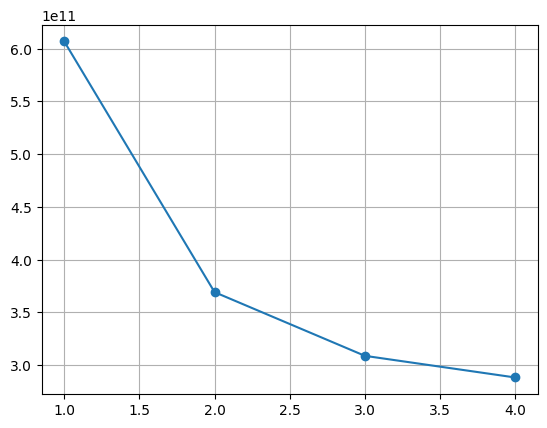

./results_gate_skip_connect/mouse_1/2024_08_13_11_20_51GATE_2encoder_cat_feature_decoder_skip_connect_bn/


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# hyper-parameters
num_epoch = 4
lr = 0.0001
weight_decay = 1e-4
# alp=0.75
hidden_dims = [adata.X.shape[1]] + [256, 64, 16]    # ????????????

# model
# model = GATE_PyG_3Layers(hidden_dims=hidden_dims).to(device)
model = GATE_2Encoder_Decoder_Init(hidden_dims=hidden_dims, fusion_method='concat').to(device)
# model = GATE_2Encoder(hidden_dims=hidden_dims, fusion_method='concat').to(device)

loss_list = []
# for training
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# 启用 batch normalization 和 dropout
model.train()
for epoch in range(1, num_epoch+1):
    loss_batch = 0
    print(f'epoch:{epoch}|{num_epoch}')
    for batch_NT in tqdm(loader_NT):
        # model.train()
        optimizer.zero_grad()
        batch_NT = batch_NT.to(device)
        # print('batch_NT.x:', batch_NT.x)
        # print('batch_NT.edge_index:', batch_NT.edge_index)
        n_id = batch_NT.n_id.to('cpu').detach().numpy()
        st_adj_batch = st_adj[n_id][:, n_id]
        edgeList = np.argwhere(st_adj_batch)
        f_con, f_spa, re = model(batch_NT.x, batch_NT.edge_index, torch.LongTensor(edgeList.T).to(device))
        loss = F.mse_loss(batch_NT.x, re, reduction="sum") #F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss_batch += loss.to('cpu').detach().numpy()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)
        optimizer.step()
        # break
    loss_list.append(loss_batch)
    print(loss_batch)
plt.plot(range(1, len(loss_list) + 1), loss_list, marker='o', linestyle='-')
plt.grid(True)
plt.show()

path = f"./results_gate_skip_connect/{mus}/"+str(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')+f'GATE_2encoder_cat_feature_decoder_skip_connect_bn/')
os.makedirs(path)
print(path)
torch.save(model.state_dict(), path+'/model_params.pth')

with open(path + 'hyperparameters.txt', 'w') as file:
    # file.write(f'whether to filter gene:{filter_gene}\n')
    # file.write(f'cluster gene number:{n_top_genes}\n')
    file.write(f'threshold to filter the FC adj:{eps}\n')
    # file.write(f'proportion_after with the eps filter:{proportion_after}\n')
    file.write(f'train stage NeighborLoader parameters:{kwargs_train}\n')
    file.write(f'evalute stage NeighborLoader parameters:{kwargs_test}\n')
    file.write(f'train num epoch:{num_epoch}\n')
    file.write(f'learning rate:{lr}\n')
    file.write(f'weight decay:{weight_decay}\n')
    file.write(f'3 layers GATE hidden dims:{hidden_dims}\n')
    # file.write(f'train loss:{loss_list}\n')

In [6]:
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# hidden_dims = [adata.X.shape[1]] + [256, 64, 16]
# # model
# model = GATE_2Encoder_Decoder_Init(hidden_dims=hidden_dims, fusion_method='concat').to(device)
# # load the pretrained parameter
# model.load_state_dict(torch.load('./results/mouse_1/2024_04_08_20_10_00GATE_2encoder_cat_feature_decoder_skip_connect_bn/model_params.pth'))
# feature_spa, feature_con = model.enc_dec_inference(NT_graph_data.x, subgraph_loader_st, subgraph_loader, device=device)
# feature_con = model.con_inference(NT_graph_data.x, subgraph_loader, device=device)
# for evaluating
layer_eval = True   # hyper-parameter!!!!!!!!!!!!1
# model evaluate ( 不启用 Batch Normalization 和 Dropout。)
model.eval()
# batch eval or no batch
if layer_eval == True:
    feature_con = model.con_inference(NT_graph_data.x, subgraph_loader, device=device)
    feature_spa = model.spa_inference(ST_graph_data.x, subgraph_loader_st, device=device)
    # add the feature to the adata
    # GATE_feature = feature.to('cpu').detach().numpy()
    # adata.uns['GATE_loss'] = loss_list
    adata.obsm['GATE_feature_spa'] = feature_spa.to('cpu').detach().numpy()
    adata.obsm['GATE_feature_con'] = feature_con.to('cpu').detach().numpy()
# all data evaluate
else:
    f_con_list = []
    f_spa_list = []
    re_list = []
    for batch_NT in tqdm(subgraph_loader):
        batch_NT = batch_NT.to(device)
        n_id = batch_NT.n_id.to('cpu').detach().numpy()
        st_adj_batch = st_adj[n_id][:, n_id]
        edgeList = np.argwhere(st_adj_batch)
        f_con, f_spa, re = model(batch_NT.x, batch_NT.edge_index, torch.LongTensor(edgeList.T).to(device))

        f_con_list.append(f_con[:batch_NT.batch_size].to('cpu').detach().numpy())
        f_spa_list.append(f_spa[:batch_NT.batch_size].to('cpu').detach().numpy())
        re_list.append(re[:batch_NT.batch_size].to('cpu').detach().numpy())

    f_con = np.concatenate(f_con_list, axis=0)
    f_spa = np.concatenate(f_spa_list, axis=0)
    re = np.concatenate(re_list, axis=0)
    adata.obsm['GATE_feature_spa'] =f_spa
    adata.obsm['GATE_feature_con'] =f_con
    adata.layers['exp_reconstructed'] = re

    # adata.obsm['GATE_feature'] = GATE_feature.to('cpu').detach().numpy()

Evaluating: 100%|██████████| 751605/751605 [01:10<00:00, 10647.52it/s]


In [21]:
re.shape

(250535, 1122)

In [22]:
f_spa.shape

(250535, 16)

In [24]:
# path = '/mnt/Data16Tc/home/haichao/code/SpaCon/ST_NT_cluster/SpaCon_apply_zxw/results/mouse_1/2024_04_08_20_10_00GATE_2encoder_cat_feature_decoder_skip_connect_bn/batch_eval_and_gene_re/'

In [7]:
# adata = sc.read_h5ad('./results/mouse_1/2024_04_08_14_56_41GATEv2_2encoder_cat_feature_decoder_skip_connect_bn/Clusters_res0.75/adata_cluster_feature.h5ad')
# adata

<Axes: title={'center': 'z'}, xlabel='UMAP1', ylabel='UMAP2'>

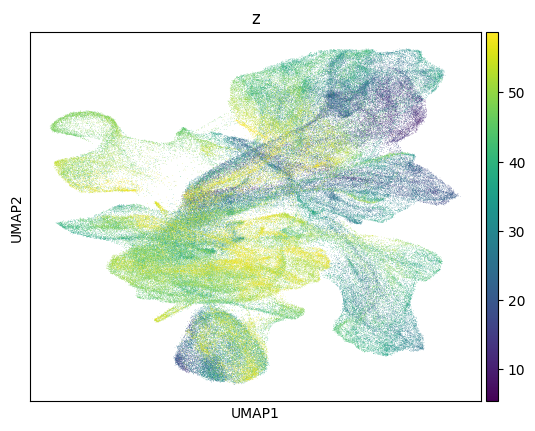

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_standard = StandardScaler()
f_con = scaler_standard.fit_transform(adata.obsm['GATE_feature_con'])
f_spa = scaler_standard.fit_transform(adata.obsm['GATE_feature_spa'])
alp=0
# f_add = alp*adata.obsm['GATE_feature_con'] + (1-alp)*adata.obsm['GATE_feature_spa']
f_add = alp*f_con + (1-alp)*f_spa
adata.obsm['GATE_feature_add'] = f_add

# concat = np.concatenate((adata.obsm['GATE_feature_con'], adata.obsm['GATE_feature_spa']), axis=1)
# adata.obsm['GATE_feature'] = concat
sc.pp.neighbors(adata, use_rep='GATE_feature_add', n_neighbors=40)
sc.tl.umap(adata)
sc.pl.umap(adata,color='z', show=False)

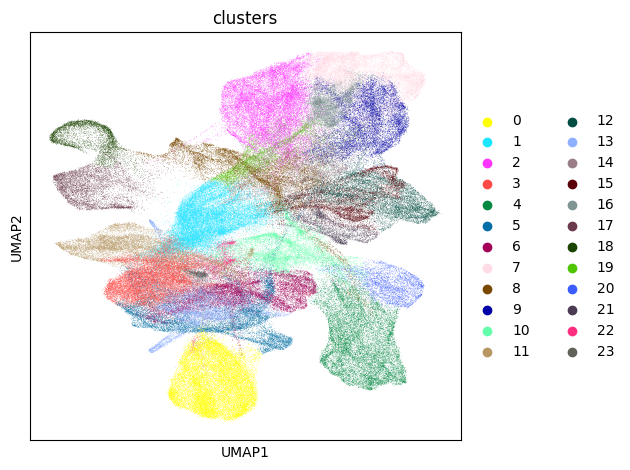

In [11]:
resolution = 0.75
fig_path = path + f'feature_add_weight{alp}/Clusters_res{resolution}/'
os.makedirs(fig_path, exist_ok=True)

sc.tl.louvain(adata,
             resolution=resolution,   # default=1  resolution = k*num (k>0)
             key_added="clusters")
sc.pl.umap(adata,color='clusters', show=False)
plt.tight_layout()
plt.savefig(fig_path+f'umap_res{resolution}.png')
adata.write_h5ad(fig_path+'/adata_cluster_feature.h5ad')

In [12]:
for it, label in enumerate(np.unique(adata.obs['section'])):
    temp_adata = adata[adata.obs['section'] == label, ]
    fig = plt.figure(figsize=figsize1)
    plt.scatter(temp_adata.obs[plot_x].values, temp_adata.obs[plot_y].values, c=temp_adata.obs['clusters'].astype('int').values, cmap='Spectral_r', s=10)  # viridis 绘制样本点
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.savefig(fig_path + '/section_'+str(label)+'.png')
    plt.close() 

for Class_i in tqdm(range(np.unique(np.array(adata.obs['clusters'])).shape[0])):  # adata.shape[0]
    # build the spot_i anndata
    Class_i_adata = adata[adata.obs['clusters']==str(Class_i)]
    # build the save path
    fig_eachclass_path = fig_path+'/cluster_result_eachclass/ClassNum_'+str(Class_i)+'_sameclasssSpotsNum_'+str(Class_i_adata.shape[0])
    if os.path.exists(fig_eachclass_path) == False:
        os.makedirs(fig_eachclass_path)  # build all the folders
    # plot same class as the spoti on every section
    for label in set(Class_i_adata.obs['section'].values):
        adata_section = adata[adata.obs['section'] == label]
        adata_class = Class_i_adata[Class_i_adata.obs['section'] == label]

        fig = plt.figure(figsize=figsize2)
        # plot
        plt.scatter(adata_section.obs[plot_x].values, adata_section.obs[plot_y].values, c='#D3D3D3', s=10)
        plt.scatter(adata_class.obs[plot_x].values, adata_class.obs[plot_y].values, c='#FF6347', s=10)
        plt.gca().invert_yaxis()
        # plt.legend(loc='upper right', prop={'size':5})
        plt.savefig(fig_eachclass_path + '/section_'+str(label)+'.png')
        # plt.show()
        plt.close()

100%|██████████| 24/24 [02:36<00:00,  6.50s/it]


<Axes: title={'center': 'z'}, xlabel='UMAP1', ylabel='UMAP2'>

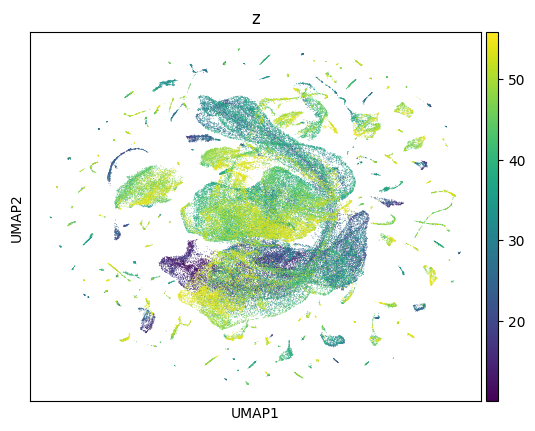

In [12]:
concat = np.concatenate((adata.obsm['GATE_feature_con'], adata.obsm['GATE_feature_spa']), axis=1)
adata.obsm['GATE_feature_cat'] = concat
sc.pp.neighbors(adata, use_rep='GATE_feature_cat', n_neighbors=40)
sc.tl.umap(adata)
sc.pl.umap(adata,color='z', show=False)

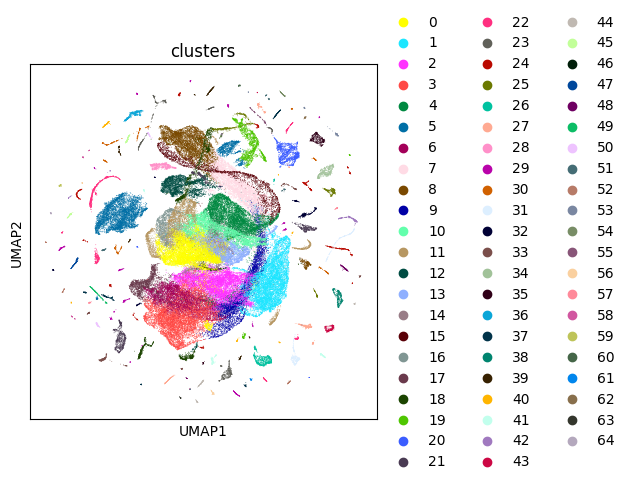

In [13]:
resolution = 0.75
fig_path = path + f'feature_concat/Clusters_res{resolution}/'
os.makedirs(fig_path, exist_ok=True)

sc.tl.louvain(adata,
             resolution=resolution,   # default=1  resolution = k*num (k>0)
             key_added="clusters")
sc.pl.umap(adata,color='clusters', show=False)
plt.tight_layout()
plt.savefig(fig_path+f'umap_res{resolution}.png')
adata.write_h5ad(fig_path+'/adata_cluster_feature.h5ad')

In [14]:
for it, label in enumerate(np.unique(adata.obs['section'])):
    temp_adata = adata[adata.obs['section'] == label, ]
    fig = plt.figure(figsize=figsize1)
    plt.scatter(temp_adata.obs[plot_x].values, temp_adata.obs[plot_y].values, c=temp_adata.obs['clusters'].astype('int').values, cmap='Spectral_r', s=10)  # viridis 绘制样本点
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.savefig(fig_path + '/section_'+str(label)+'.png')
    plt.close() 

for Class_i in tqdm(range(np.unique(np.array(adata.obs['clusters'])).shape[0])):  # adata.shape[0]
    Class_i_adata = adata[adata.obs['clusters']==str(Class_i)]
    fig_eachclass_path = fig_path+'/cluster_result_eachclass/ClassNum_'+str(Class_i)+'_sameclasssSpotsNum_'+str(Class_i_adata.shape[0])
    if os.path.exists(fig_eachclass_path) == False:
        os.makedirs(fig_eachclass_path)  # build all the folders
    for label in set(Class_i_adata.obs['section'].values):
        adata_section = adata[adata.obs['section'] == label]
        adata_class = Class_i_adata[Class_i_adata.obs['section'] == label]
        fig = plt.figure(figsize=figsize2)
        plt.scatter(adata_section.obs[plot_x].values, adata_section.obs[plot_y].values, c='#D3D3D3', s=10)
        plt.scatter(adata_class.obs[plot_x].values, adata_class.obs[plot_y].values, c='#FF6347', s=10)
        plt.gca().invert_yaxis()
        # plt.legend(loc='upper right', prop={'size':5})
        plt.savefig(fig_eachclass_path + '/section_'+str(label)+'.png')
        # plt.show()
        plt.close()

100%|██████████| 65/65 [02:17<00:00,  2.12s/it]
